# Convolutional Neural Networks: Application

In this notebook, you will:

- Implement helper functions that you will use when implementing a TensorFlow model
- Implement a fully functioning ConvNet using TensorFlow 

**After this you will be able to:**

- Build and train a ConvNet in TensorFlow for a classification problem 

## 1.0 - TensorFlow model

In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

As usual, we will start by loading in the packages. 

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

Run the next cell to load the "SIGNS" dataset you are going to use.

In [3]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 2


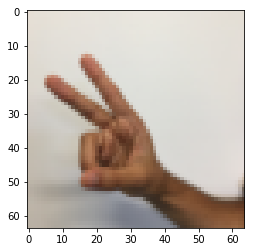

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


### 1.1 - Create placeholders

TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

In [11]:
tf.compat.v1.disable_eager_execution()
# NOTE from Harry - above was necessary as placeholders arent used in TensorFlow 2.0. 

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.compat.v1.placeholder("float", [None, n_H0, n_W0, n_C0])
    Y = tf.compat.v1.placeholder("float", [None, n_y])
    
    return X, Y

In [12]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(None, 6), dtype=float32)


### 1.2 - Initialize parameters

You will initialize weights/filters $W1$ and $W2$ using `tf.contrib.layers.xavier_initializer(seed = 0)`. You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. We will talk more about that later in this assignment.

In [24]:

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function to make the grading simpler.
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.compat.v1.set_random_seed(1)                              # so that your "random" numbers match ours
        
    W1 = tf.compat.v1.get_variable("W1", [4, 4, 3, 8], initializer = tf.random_normal_initializer(seed=0))
    W2 = tf.compat.v1.get_variable("W2", [2, 2, 8, 16], initializer = tf.random_normal_initializer(seed=0))
    
#     NOTE from Harry - replaced Xavier initialisation abovewith random normal as TF 2.0 doesnt have Xavier.
    
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [25]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1[1,1,1] = \n" + str(parameters["W1"].eval()[1,1,1]))
    print("W1.shape: " + str(parameters["W1"].shape))
    print("\n")
    print("W2[1,1,1] = \n" + str(parameters["W2"].eval()[1,1,1]))
    print("W2.shape: " + str(parameters["W2"].shape))

W1[1,1,1] = 
[-0.00139378  0.0719257  -0.00144897 -0.0616775   0.02778022 -0.05156605
  0.05875546  0.06870179]
W1.shape: (4, 4, 3, 8)


W2[1,1,1] = 
[-0.08953997 -0.03509111  0.02014567 -0.06948619  0.00565307 -0.00482221
  0.01691291 -0.00847536  0.05977022  0.07276908 -0.11607045  0.05015796
  0.03687169 -0.0009075  -0.0285339  -0.06196459]
W2.shape: (2, 2, 8, 16)


In [57]:

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity and grading purposes, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.compat.v1.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.compat.v1.layers.dense(F, units=6, activation=None)

#     NOTE from Harry:
#         for TF 2.0 compatability I changed:
#             fully_connected ---> dense
#     This has changed the value of Z3 from its expected value in the assignment
#     And thus the cost 
    return Z3

In [58]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = \n" + str(a))

Z3 = 
[[ 0.20206812 -0.12311858 -0.2731213   0.03295732 -0.10049979 -0.06972905]
 [ 0.19169444 -0.1701842  -0.19397002  0.03091463 -0.13353615 -0.05555741]]


**Expected Output**:

```
Z3 = 
[[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376  0.46852064]
 [-0.17601591 -1.57972014 -1.4737016  -2.61672091 -1.00810647  0.5747785 ]]
```

### 1.4 - Compute cost

Implement the compute cost function below. Remember that the cost function helps the neural network see how much the model's predictions differ from the correct labels.  By adjusting the weights of the network to reduce the cost, the neural network can improve its predictions.


In [60]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    cost = tf.compat.v1.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

In [61]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 1.1006017


## 1.5 Model 

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally you will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function.
(https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [68]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.compat.v1.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(64, 64, 3, 6)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.compat.v1.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                _ , temp_cost = sess.run(fetches = [optimizer,cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Run the following cell to train your model for 100 epochs. Check if your cost after epoch 0 and 5 matches our output. If not, stop the cell and go back to your code!

Cost after epoch 0: 1.908249
Cost after epoch 5: 1.273500
Cost after epoch 10: 0.743398
Cost after epoch 15: 0.598862
Cost after epoch 20: 0.444420
Cost after epoch 25: 0.404252
Cost after epoch 30: 0.334873
Cost after epoch 35: 0.297804
Cost after epoch 40: 0.288603
Cost after epoch 45: 0.261880
Cost after epoch 50: 0.209363
Cost after epoch 55: 0.208310
Cost after epoch 60: 0.183833
Cost after epoch 65: 0.173086
Cost after epoch 70: 0.177378
Cost after epoch 75: 0.166579
Cost after epoch 80: 0.160577
Cost after epoch 85: 0.131223
Cost after epoch 90: 0.114581
Cost after epoch 95: 0.155447


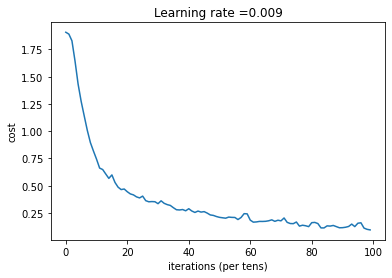

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.98425925
Test Accuracy: 0.8666667


In [69]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

**Expected output**: although it may not match perfectly, your expected output should be close to ours and your cost value should decrease.

<table> 
<tr>
    <td> 
    **Cost after epoch 0 =**
    </td>

    <td> 
      1.917929
    </td> 
</tr>
<tr>
    <td> 
    **Cost after epoch 5 =**
    </td>

    <td> 
      1.506757
    </td> 
</tr>
<tr>
    <td> 
    **Train Accuracy   =**
    </td>

    <td> 
      0.940741
    </td> 
</tr> 

<tr>
    <td> 
    **Test Accuracy   =**
    </td>

    <td> 
      0.783333
    </td> 
</tr> 
</table>